<h4>
View and Condense Data
</h4>

In [2]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split


In [3]:
df = pd.read_csv('btcusd_1-min_data.csv')

In [4]:
df.head()

,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0


In [5]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
#Now the time stamp will look like this:
# Eg. 2024-11-25 12:30:00
# Eg. 2024-11-25 12:31:00
df.head()

,Timestamp,Open,High,Low,Close,Volume
0,2012-01-01 10:01:00,4.58,4.58,4.58,4.58,0.0
1,2012-01-01 10:02:00,4.58,4.58,4.58,4.58,0.0
2,2012-01-01 10:03:00,4.58,4.58,4.58,4.58,0.0
3,2012-01-01 10:04:00,4.58,4.58,4.58,4.58,0.0
4,2012-01-01 10:05:00,4.58,4.58,4.58,4.58,0.0


In [6]:
# Define start and end dates for the time range
start_date = '2020-01-01 00:00:00'
end_date = '2024-08-31 23:59:59'

# Convert Timestamp column to datetime if not already
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Filter the entire dataset for the given range
filtered_data = df[(df['Timestamp'] >= start_date) & (df['Timestamp'] <= end_date)]

# Loop through each month from January 2020 to August 2024
results = []  # Store results for each month
for year in range(2020, 2025):
    for month in range(1, 13):  # Months from January to December
        # Stop the loop after August 2024
        if year == 2024 and month > 8:
            break

        # Get the start and end dates for the current month
        month_start = pd.Timestamp(year, month, 1)
        month_end = pd.Timestamp(year, month, pd.Timestamp(year=year, month=month, day=1).days_in_month)

        # Filter data for the current month
        monthly_data = filtered_data[(filtered_data['Timestamp'] >= month_start) & (filtered_data['Timestamp'] <= month_end)]

        # Check if there is any data for the current month
        if not monthly_data.empty:
            # Group the data by day and calculate the average for each day
            daily_avg_data = monthly_data.resample('D', on='Timestamp').mean()

            # Append to results
            results.append(daily_avg_data)

# Combine all monthly results into a single DataFrame (optional)
final_df = pd.concat(results)
print(final_df.shape)
print(final_df)

(1705, 5)
                    Open          High           Low         Close    Volume
Timestamp                                                                   
2020-01-01   7186.399375   7188.638083   7184.474021   7186.464500  0.841038
2020-01-02   7124.028590   7126.805507   7121.185118   7124.040660  2.078489
2020-01-03   7143.260563   7147.477215   7139.398257   7143.447729  5.870052
2020-01-04   7316.682979   7319.481507   7313.819771   7316.615736  2.503988
2020-01-05   7417.108132   7419.795437   7414.667618   7417.132611  1.815936
...                  ...           ...           ...           ...       ...
2024-08-27  62623.192361  62638.263194  62607.734028  62623.297917  0.951731
2024-08-28  59526.847222  59553.024306  59497.836111  59524.722917  2.699902
2024-08-29  59667.187500  59688.853472  59645.680556  59667.342361  1.720718
2024-08-30  59152.263889  59172.700000  59130.343056  59151.475694  1.507046
2024-08-31  58693.000000  58789.000000  58693.000000  58789.000000

<h4>
Post Processing
</h4>

In [7]:
# 1. Load the Kaggle dataset

# 2. Select features (X) and target (y)
X = final_df[['Open', 'High', 'Volume', 'Close']]  # Predictor variables
y = final_df['Low']                               # Target variable

# Add intercept to X
X = np.column_stack((np.ones(X.shape[0]), X))  # Adds a column of 1s for the intercept

# 3. Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Set Size: {X_train.shape[0]} samples")
print(f"Test Set Size: {X_test.shape[0]} samples\n")

# 4. Fit the model (OLS method)
XtX = X_train.T @ X_train                # X^T * X
XtX_inv = np.linalg.inv(XtX)             # (X^T * X)^(-1)
beta_hat = XtX_inv @ X_train.T @ y_train # beta_hat = (X^T * X)^(-1) * X^T * y

print("Regression Coefficients (beta_hat):")
print(beta_hat, "\n")

# 5. Make predictions on training data
y_train_pred = X_train @ beta_hat
y_test_pred = X_test @ beta_hat

# 6. Calculate residuals, SSE, residual variance, and covariance matrix
residuals_train = y_train - y_train_pred        # Residuals: e = y - y_hat
sse = residuals_train.T @ residuals_train       # SSE = e^T * e
n, p = X_train.shape
sigma_squared = sse / (n - p)                   # Residual variance: sigma^2 = SSE / (n - p)
var_beta = sigma_squared * XtX_inv              # Variance-Covariance Matrix: Var(beta)

print("SSE (Sum of Squared Errors):")
print(f"{sse:.4f}\n")

print("Residual Variance (sigma^2):")
print(f"{sigma_squared:.4f}\n")

print("Variance-Covariance Matrix of beta_hat:")
print(var_beta, "\n")

# 7. Calculate RMSE on the test set
rmse = np.sqrt(np.mean((y_test - y_test_pred) ** 2))  # RMSE = sqrt(mean((y - y_pred)^2))

print("Root Mean Squared Error (RMSE) on Test Set:")
print(f"{rmse:.4f}")


Training Set Size: 1364 samples
Test Set Size: 341 samples

Regression Coefficients (beta_hat):
[ 0.49303959  0.96703236 -0.96986367 -0.06057362  1.00279837] 

SSE (Sum of Squared Errors):
10534.3366

Residual Variance (sigma^2):
7.7515

Variance-Covariance Matrix of beta_hat:
[[ 4.30802343e-02 -5.10335346e-04  7.05561464e-04 -3.87991223e-03
  -1.96307104e-04]
 [-5.10335346e-04  9.06286175e-05 -3.81615565e-05  1.09610193e-04
  -5.24451072e-05]
 [ 7.05561464e-04 -3.81615565e-05  7.01229929e-05 -1.48519683e-04
  -3.19986734e-05]
 [-3.87991223e-03  1.09610193e-04 -1.48519683e-04  8.28897215e-04
   3.90163712e-05]
 [-1.96307104e-04 -5.24451072e-05 -3.19986734e-05  3.90163712e-05
   8.44591022e-05]] 

Root Mean Squared Error (RMSE) on Test Set:
1.8241


In [8]:
# 8. Calculate R² (Coefficient of Determination) on the test set
ss_total = np.sum((y_test - np.mean(y_test)) ** 2)  # Total Sum of Squares
ss_residual = np.sum((y_test - y_test_pred) ** 2)   # Residual Sum of Squares
r_squared = 1 - (ss_residual / ss_total)             # R² = 1 - (SS_residual / SS_total)

print("R-squared (R²) on Test Set:")
print(f"{r_squared:.4f}")

# 9. Calculate Mean Absolute Error (MAE) on the test set
mae = np.mean(np.abs(y_test - y_test_pred))         # MAE = mean(abs(y - y_pred))

print("Mean Absolute Error (MAE) on Test Set:")
print(f"{mae:.4f}")

R-squared (R²) on Test Set:
1.0000
Mean Absolute Error (MAE) on Test Set:
0.9019


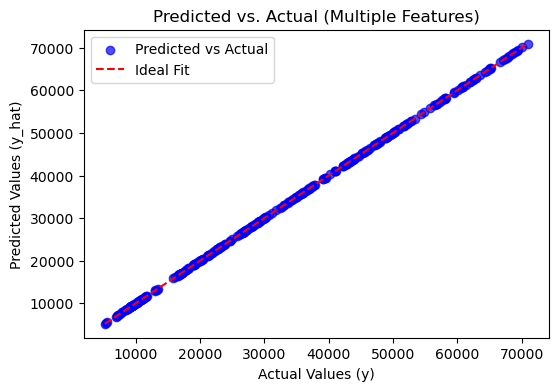

In [9]:
# Scatter plot of predicted vs. actual values for test set
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_test_pred, color='blue', alpha=0.7, label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Values (y)')
plt.ylabel('Predicted Values (y_hat)')
plt.title('Predicted vs. Actual (Multiple Features)')
plt.legend()
plt.show()

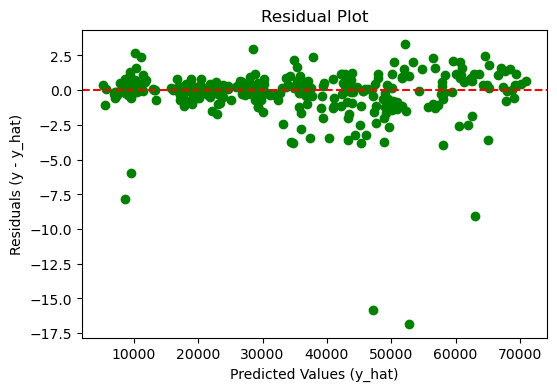

In [10]:
# Residuals
residuals_test = y_test - y_test_pred

plt.figure(figsize=(6, 4))
plt.scatter(y_test_pred, residuals_test, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values (y_hat)')
plt.ylabel('Residuals (y - y_hat)')
plt.title('Residual Plot')
plt.show()


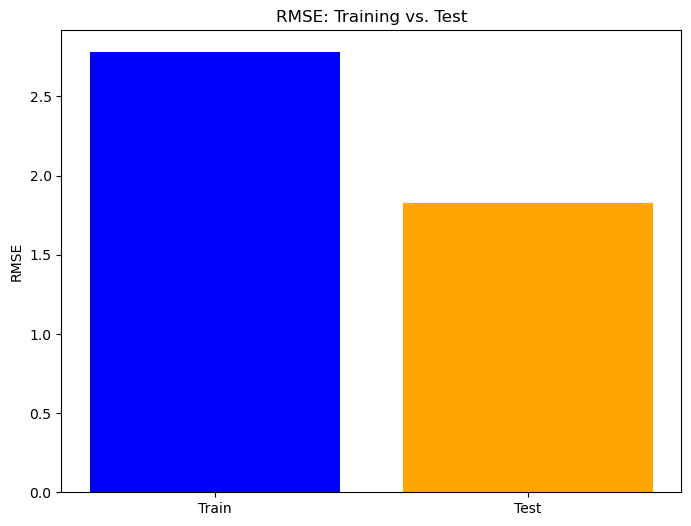

In [11]:
# Calculate RMSE for training data
rmse_train = np.sqrt(np.mean(residuals_train ** 2))

plt.figure(figsize=(8, 6))
plt.bar(['Train', 'Test'], [rmse_train, rmse], color=['blue', 'orange'])
plt.ylabel('RMSE')
plt.title('RMSE: Training vs. Test')
plt.show()

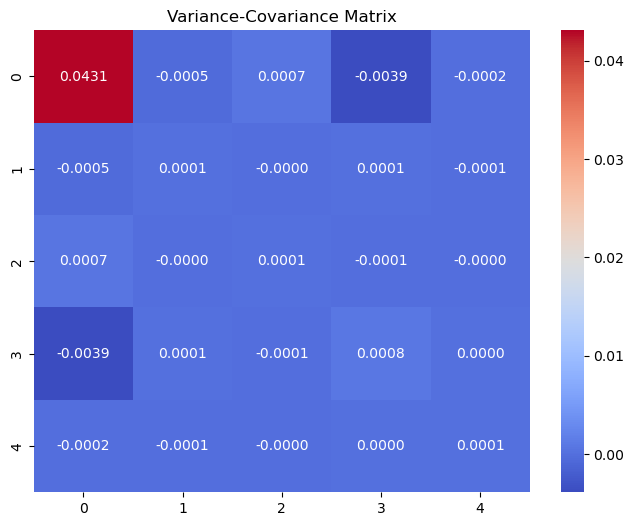

In [12]:
plt.figure(figsize=(8, 6))
sns.heatmap(var_beta, annot=True, fmt=".4f", cmap='coolwarm', cbar=True)
plt.title('Variance-Covariance Matrix')
plt.show()

In [13]:
final_df['Low'].max()

72492.14930555556

In [14]:
final_df['Low'].min()

5052.069076388889

In [15]:
(final_df['Low'].max())-(final_df['Low'].min())

67440.08022916668